In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('RecSys2019_DeepLearning_Evaluation-master')
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from MatrixFactorization.NMFRecommender import NMFRecommender
from MatrixFactorization.IALSRecommender import IALSRecommender
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from model.base import AbstractRecommender
from sklearn.preprocessing import normalize
from reckit import Configurator
from importlib.util import find_spec
from importlib import import_module
from reckit import typeassert
import scipy as sp
import os
import sys
import numpy as np
import random
import torch

def _set_random_seed(seed=2021):
    
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    print("set pytorch seed")

is_windows = sys.platform.startswith('win')
if is_windows:
    root_dir = './'
    data_dir = './dataset/'
else:
    root_dir = './'
    data_dir = './dataset/'
config = Configurator(root_dir, data_dir)
config.add_config(root_dir + "NeuRec.ini", section="NeuRec")
config.parse_cmd()
os.environ['CUDA_VISIBLE_DEVICES'] = str(config["gpu_id"])
_set_random_seed(2021) # config["seed"])

model_cfg = os.path.join(root_dir + "conf", config.recommender+".ini")
config.add_config(model_cfg, section="hyperparameters", used_as_summary=True)

set pytorch seed


In [5]:
config.seed = 2022

In [21]:
class SLIM(AbstractRecommender):
    def __init__(self, config):
        super(SLIM, self).__init__(config)

    def train_model(self, epochs=1000):
        UI = self.dataset.train_csr_mat
        self.UI = UI
        slim = SLIM_BPR_Cython(UI)
        slim.fit(epochs=epochs, topK=10**10)

        self.W = slim.W_sparse

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return (self.UI[users] @ self.W).todense()

In [22]:
class ALS(AbstractRecommender):
    def __init__(self, config):
        super(ALS, self).__init__(config)

    def train_model(self, epochs = 300,
                        num_factors = 20,
                        confidence_scaling = "linear",
                        alpha = 1.0,
                        epsilon = 1.0,
                        reg = 1e-3,
                        init_mean=0.0,
                        init_std=0.1,
                        validation_every_n=5):
        UI = self.dataset.train_csr_mat
        als = IALSRecommender(UI)
        als.fit(epochs = epochs,
                num_factors = num_factors,
                confidence_scaling = confidence_scaling,
                alpha = alpha,
                epsilon = epsilon,
                reg = reg,
                init_mean=init_mean,
                init_std=init_std,
                validation_every_n=5)

        self.ITEM_factors = als.ITEM_factors
        self.USER_factors = als.USER_factors

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return np.dot(self.USER_factors[users], self.ITEM_factors.T)

In [23]:
class NNMF(AbstractRecommender):
    def __init__(self, config):
        super(NNMF, self).__init__(config)

    def train_model(self, num_factors = 100,
                          l1_ratio    = 0.05,
                          alpha_W     = 0.,
                          init_type   = 'random',
                          beta_loss   = "frobenius",
                          max_iter    = 500,
                          verbose     = True):
        UI = self.dataset.train_csr_mat
        nnmf = NMFRecommender(UI)
        nnmf.fit(num_factors = num_factors,
                 l1_ratio    = l1_ratio,
                 alpha_W     = alpha_W,
                 init_type   = init_type,
                 beta_loss   = beta_loss,
                 max_iter    = max_iter,
                 verbose     = verbose)

        self.ITEM_factors = nnmf.ITEM_factors
        self.USER_factors = nnmf.USER_factors

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return np.dot(self.USER_factors[users], self.ITEM_factors.T)

In [24]:
class PureSVD(AbstractRecommender):
    def __init__(self, config):
        super(PureSVD, self).__init__(config)

    def train_model(self, num_factors=100):
        UI = self.dataset.train_csr_mat
        svd = PureSVDRecommender(UI)
        svd.fit(num_factors=num_factors)

        self.ITEM_factors = svd.ITEM_factors
        self.USER_factors = svd.USER_factors

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return np.dot(self.USER_factors[users], self.ITEM_factors.T)

In [26]:
class UserKNN(AbstractRecommender):
    def __init__(self, config):
        super(UserKNN, self).__init__(config)

    def train_model(self, topK=1000,
                          shrink=100,
                          feature_weighting="none"):
        self.UI = self.dataset.train_csr_mat
        model_ = UserKNNCFRecommender(self.UI)
        model_.fit(topK=topK,
                   shrink=shrink,
                   feature_weighting=feature_weighting)

        self.W = model_.W_sparse

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return (self.W[users] @ self.UI).todense()

In [27]:
class ItemKNN(AbstractRecommender):
    def __init__(self, config):
        super(ItemKNN, self).__init__(config)

    def train_model(self, topK=1000,
                          shrink=100,
                          similarity='cosine',
                          feature_weighting="none"):
        self.UI = self.dataset.train_csr_mat
        model_ = ItemKNNCFRecommender(self.UI)
        model_.fit(topK=topK,
                   shrink=shrink,
                   similarity=similarity,
                   feature_weighting=feature_weighting)

        self.W = model_.W_sparse

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return (self.UI[users] @ self.W).todense()

In [26]:
class RP3beta(AbstractRecommender):
    def __init__(self, config):
        super(RP3beta, self).__init__(config)
    
    def train_model(self, alpha=1, beta=0, q_u=0, q_i=0):
        UI = self.dataset.train_csr_mat
        I_sum = np.array(UI.sum(0))
        U_sum = np.array(UI.sum(1))
        q_i_val = np.quantile(I_sum, q_i)
        q_u_val = np.quantile(U_sum, q_u)
        print('U:', q_u_val, 'I:', q_i_val)
        I_index = I_sum >= q_i_val
        U_index = U_sum >= q_u_val
        UI = UI.multiply(I_index)
        UI = sp.sparse.csr_matrix(UI.multiply(U_index))
        self.UI = UI 
        Pui = normalize(UI, norm='l1', axis=1)
        Pui = Pui.power(alpha)

        IU = UI.T
        Piu_sum = np.array(IU.sum(1)).reshape(1, -1)
        Piu = normalize(IU, norm='l1', axis=1)
        Piu = Piu.power(alpha)

        self.norm = Piu_sum ** beta
        self.W = Piu @ Pui

        print('model traind')
        current_result, buf = self.evaluate_model()
        self.logger.info("\t\t%s" % buf)
        return current_result

    def evaluate_model(self):
        return self.evaluator.evaluate(self)

    def predict(self, users):
        return (self.UI[users] @ self.W).todense()/(self.norm + 1e-10)

In [37]:
config.dataset = 'ifashion'

In [38]:
'''
amazon-book: alpha=1., beta=0.
yelp2018: alpha=0.7, beta=0.5
ifashion: alpha=0.315308, beta=0.056393
'''
model = RP3beta(config)

/home/daniilstrunov/nogcn/SGL-Torch-main/data/dataset.py:317: UserWarning: ./dataset/ifashion/ifashion.valid does not exist.
  warnings.warn("%s does not exist." % valid_file)
/home/daniilstrunov/nogcn/SGL-Torch-main/data/dataset.py:331: UserWarning: ./dataset/ifashion/ifashion.user2id does not exist.
  warnings.warn("%s does not exist." % user2id_file)
/home/daniilstrunov/nogcn/SGL-Torch-main/data/dataset.py:339: UserWarning: ./dataset/ifashion/ifashion.item2id does not exist.
  warnings.warn("%s does not exist." % item2id_file)


Item degree grouping...
User degree grouping...
Data loading finished
2023-04-18 19:03:20.642: my pid: 2475
2023-04-18 19:03:20.643: model: __main__
2023-04-18 19:03:20.643: Dataset statistics:
Name: ifashion
The number of users: 300000
The number of items: 81614
The number of ratings: 1607813
Average actions of users: 5.36
Average actions of items: 19.70
The sparsity of the dataset: 99.993433%

The number of training: 1255447
The number of validation: 0
The number of testing: 352366
2023-04-18 19:03:20.644: NeuRec:[NeuRec]:
recommender=SGL
dataset=yelp2018
file_column=UI
sep=','
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "NDCG"]
top_k=[20]
test_thread=8
test_batch_size=128
seed=2021
start_testing_epoch=0

SGL:[hyperparameters]:
aug_type=ED
reg=1e-4
embed_size=64
n_layers=3
ssl_reg=0.1
ssl_ratio=0.1
ssl_temp=0.2
ssl_mode=both_side
lr=0.001
learner=adam
adj_type=pre
epochs=1000
batch_size=2048
num_negatives=1
param_init=xavier_uniform
stddev=0.01
verbose=1
stop_cnt=10
pretrain

In [39]:
model.train_model(alpha=0.315308, beta=0.056393, q_u=0.0, q_i=0.0)

U: 1.0 I: 1.0
model traind
2023-04-18 19:06:04.737: 		0.00680723  	0.10841475  	0.05410637  


array([0.00680723, 0.10841475, 0.05410637], dtype=float32)

In [ ]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 1)
    beta = trial.suggest_float('beta', 0, 1)
    q_u = 0.99
    q_i = 0.0
    current_result = model.train_model(alpha=alpha,
                                       beta=beta,
                                       q_u=q_u,
                                       q_i=q_i)
    return current_result[1]

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-03-22 21:10:02,303] A new study created in memory with name: no-name-fb1678a0-a85c-4838-8dac-09ab72ec1ce9


U: 21.0 I: 1.0
model traind
2023-03-22 21:12:08.875: 		0.00524175  	0.08358254  	0.04276825  


[I 2023-03-22 21:12:08,876] Trial 0 finished with value: 0.08358253538608551 and parameters: {'alpha': 0.034742458127195563, 'beta': 0.2992919117662973}. Best is trial 0 with value: 0.08358253538608551.


U: 21.0 I: 1.0
model traind
2023-03-22 21:14:16.069: 		0.00341553  	0.05240951  	0.02723281  


[I 2023-03-22 21:14:16,071] Trial 1 finished with value: 0.05240951105952263 and parameters: {'alpha': 0.1714956800986197, 'beta': 0.42873599190205847}. Best is trial 0 with value: 0.08358253538608551.


U: 21.0 I: 1.0
model traind
2023-03-22 21:16:20.952: 		0.00604757  	0.09828963  	0.04959533  


[I 2023-03-22 21:16:20,953] Trial 2 finished with value: 0.09828963130712509 and parameters: {'alpha': 0.4834797178830985, 'beta': 0.13409053937394133}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:18:29.241: 		0.00014562  	0.00238236  	0.00083289  


[I 2023-03-22 21:18:29,243] Trial 3 finished with value: 0.0023823606316000223 and parameters: {'alpha': 0.758600453281314, 'beta': 0.941891340119349}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:20:36.619: 		0.00357691  	0.05976864  	0.02732939  


[I 2023-03-22 21:20:36,620] Trial 4 finished with value: 0.059768639504909515 and parameters: {'alpha': 0.7691299948954292, 'beta': 0.2718439124882567}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:22:44.566: 		0.00261358  	0.04487399  	0.01915952  


[I 2023-03-22 21:22:44,568] Trial 5 finished with value: 0.04487398639321327 and parameters: {'alpha': 0.8853274095113592, 'beta': 0.3233462728945894}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:24:53.300: 		0.00016180  	0.00259772  	0.00089336  


[I 2023-03-22 21:24:53,301] Trial 6 finished with value: 0.002597724087536335 and parameters: {'alpha': 0.2838785981829032, 'beta': 0.705908547360186}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:27:01.182: 		0.00015064  	0.00247442  	0.00087082  


[I 2023-03-22 21:27:01,183] Trial 7 finished with value: 0.002474420238286257 and parameters: {'alpha': 0.8613376274626795, 'beta': 0.9850622984727313}. Best is trial 2 with value: 0.09828963130712509.


U: 21.0 I: 1.0
model traind
2023-03-22 21:29:07.899: 		0.00640742  	0.10562919  	0.05244550  


[I 2023-03-22 21:29:07,900] Trial 8 finished with value: 0.10562919080257416 and parameters: {'alpha': 0.21968597996143369, 'beta': 0.046250500142676954}. Best is trial 8 with value: 0.10562919080257416.


U: 21.0 I: 1.0
model traind
2023-03-22 21:31:14.487: 		0.00483147  	0.07625276  	0.03946983  


[I 2023-03-22 21:31:14,488] Trial 9 finished with value: 0.0762527585029602 and parameters: {'alpha': 0.01231785822338849, 'beta': 0.3350402285840228}. Best is trial 8 with value: 0.10562919080257416.


U: 21.0 I: 1.0
model traind
2023-03-22 21:33:20.481: 		0.00644037  	0.10586046  	0.05283996  


[I 2023-03-22 21:33:20,483] Trial 10 finished with value: 0.10586046427488327 and parameters: {'alpha': 0.39849949435202725, 'beta': 0.008446488488235641}. Best is trial 10 with value: 0.10586046427488327.


U: 21.0 I: 1.0
model traind
2023-03-22 21:35:27.819: 		0.00645228  	0.10612746  	0.05287049  


[I 2023-03-22 21:35:27,821] Trial 11 finished with value: 0.10612746328115463 and parameters: {'alpha': 0.3609779228782747, 'beta': 0.015347092279134}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:37:34.675: 		0.00640592  	0.10519428  	0.05256080  


[I 2023-03-22 21:37:34,676] Trial 12 finished with value: 0.10519427806138992 and parameters: {'alpha': 0.43959489368263244, 'beta': 0.0006979220335839864}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:39:42.791: 		0.00569260  	0.09280981  	0.04665062  


[I 2023-03-22 21:39:42,793] Trial 13 finished with value: 0.09280981123447418 and parameters: {'alpha': 0.581134592564706, 'beta': 0.12961647832415224}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:41:49.748: 		0.00622721  	0.10117841  	0.05100989  


[I 2023-03-22 21:41:49,749] Trial 14 finished with value: 0.10117840766906738 and parameters: {'alpha': 0.3572921384099736, 'beta': 0.15480863788088828}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:43:57.603: 		0.00609190  	0.09988333  	0.05020043  


[I 2023-03-22 21:43:57,604] Trial 15 finished with value: 0.09988332539796829 and parameters: {'alpha': 0.5867320468740319, 'beta': 0.0009149395703033792}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:46:05.152: 		0.00117222  	0.01865142  	0.00755665  


[I 2023-03-22 21:46:05,154] Trial 16 finished with value: 0.01865142211318016 and parameters: {'alpha': 0.3682855823657741, 'beta': 0.5463479051859245}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:48:12.904: 		0.00532217  	0.08594099  	0.04310272  


[I 2023-03-22 21:48:12,906] Trial 17 finished with value: 0.08594098687171936 and parameters: {'alpha': 0.5034713217674771, 'beta': 0.223158888628383}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:50:19.380: 		0.00633854  	0.10425133  	0.05186376  


[I 2023-03-22 21:50:19,381] Trial 18 finished with value: 0.10425133258104324 and parameters: {'alpha': 0.16085379913849168, 'beta': 0.11138295269046028}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:52:26.558: 		0.00620189  	0.10064837  	0.05066202  


[I 2023-03-22 21:52:26,559] Trial 19 finished with value: 0.10064837336540222 and parameters: {'alpha': 0.3176105461543376, 'beta': 0.1732204471051747}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:54:33.650: 		0.00637744  	0.10427336  	0.05237198  


[I 2023-03-22 21:54:33,651] Trial 20 finished with value: 0.10427336394786835 and parameters: {'alpha': 0.42530853810973057, 'beta': 0.06786970992552155}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:56:42.039: 		0.00640295  	0.10572400  	0.05237115  


[I 2023-03-22 21:56:42,041] Trial 21 finished with value: 0.10572399944067001 and parameters: {'alpha': 0.2437016538288776, 'beta': 0.01160435251064373}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 21:58:49.514: 		0.00641748  	0.10593025  	0.05251191  


[I 2023-03-22 21:58:49,516] Trial 22 finished with value: 0.10593024641275406 and parameters: {'alpha': 0.2710704940897808, 'beta': 0.003992251074141315}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:00:56.742: 		0.00643384  	0.10534429  	0.05270689  


[I 2023-03-22 22:00:56,743] Trial 23 finished with value: 0.10534428805112839 and parameters: {'alpha': 0.3446487086640799, 'beta': 0.08551018514275863}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:03:03.203: 		0.00601351  	0.09788328  	0.04918380  


[I 2023-03-22 22:03:03,204] Trial 24 finished with value: 0.09788328409194946 and parameters: {'alpha': 0.10856899366088446, 'beta': 0.2041332049319297}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:05:11.160: 		0.00641169  	0.10511043  	0.05254685  


[I 2023-03-22 22:05:11,161] Trial 25 finished with value: 0.10511042922735214 and parameters: {'alpha': 0.275553686827605, 'beta': 0.10183717374604495}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:07:17.751: 		0.00602617  	0.09747491  	0.04919780  


[I 2023-03-22 22:07:17,752] Trial 26 finished with value: 0.09747491031885147 and parameters: {'alpha': 0.22201698991184893, 'beta': 0.2150192025515405}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:09:25.211: 		0.00639847  	0.10462890  	0.05250929  


[I 2023-03-22 22:09:25,213] Trial 27 finished with value: 0.10462889820337296 and parameters: {'alpha': 0.3981677166025426, 'beta': 0.07543207956013243}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:11:31.438: 		0.00642939  	0.10608380  	0.05260700  


[I 2023-03-22 22:11:31,440] Trial 28 finished with value: 0.10608380287885666 and parameters: {'alpha': 0.2832854435075175, 'beta': 0.003453993768254688}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:13:38.054: 		0.00612689  	0.10034766  	0.05017355  


[I 2023-03-22 22:13:38,056] Trial 29 finished with value: 0.10034766048192978 and parameters: {'alpha': 0.0822179829762964, 'beta': 0.1668001913759915}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:15:44.308: 		0.00558630  	0.08973275  	0.04554555  


[I 2023-03-22 22:15:44,309] Trial 30 finished with value: 0.08973275125026703 and parameters: {'alpha': 0.08215620089079734, 'beta': 0.26789299999657024}. Best is trial 11 with value: 0.10612746328115463.


U: 21.0 I: 1.0
model traind
2023-03-22 22:17:50.275: 		0.00643962  	0.10620567  	0.05270607  


[I 2023-03-22 22:17:50,276] Trial 31 finished with value: 0.10620567202568054 and parameters: {'alpha': 0.3121479736641724, 'beta': 0.00022535548887725465}. Best is trial 31 with value: 0.10620567202568054.


U: 21.0 I: 1.0
model traind
2023-03-22 22:19:55.909: 		0.00643664  	0.10590982  	0.05273522  


[I 2023-03-22 22:19:55,910] Trial 32 finished with value: 0.10590982437133789 and parameters: {'alpha': 0.26151483013582283, 'beta': 0.06582990432828045}. Best is trial 31 with value: 0.10620567202568054.


U: 21.0 I: 1.0
model traind
2023-03-22 22:22:01.453: 		0.00636926  	0.10499310  	0.05214662  


[I 2023-03-22 22:22:01,454] Trial 33 finished with value: 0.10499310493469238 and parameters: {'alpha': 0.18275215433826994, 'beta': 0.06960729320413218}. Best is trial 31 with value: 0.10620567202568054.


U: 21.0 I: 1.0
model traind
2023-03-22 22:24:07.068: 		0.00636999  	0.10401534  	0.05215621  


[I 2023-03-22 22:24:07,070] Trial 34 finished with value: 0.10401533544063568 and parameters: {'alpha': 0.3062535108281872, 'beta': 0.12761423101566216}. Best is trial 31 with value: 0.10620567202568054.


U: 21.0 I: 1.0
model traind
2023-03-22 22:26:13.173: 		0.00644390  	0.10626625  	0.05274016  


[I 2023-03-22 22:26:13,174] Trial 35 finished with value: 0.10626625269651413 and parameters: {'alpha': 0.30918695061790447, 'beta': 0.004793173511273886}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:28:20.210: 		0.00628455  	0.10302728  	0.05144158  


[I 2023-03-22 22:28:20,212] Trial 36 finished with value: 0.10302727669477463 and parameters: {'alpha': 0.16525493480313697, 'beta': 0.1426131912731813}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:30:26.932: 		0.00645786  	0.10600831  	0.05293038  


[I 2023-03-22 22:30:26,933] Trial 37 finished with value: 0.10600830614566803 and parameters: {'alpha': 0.33399558945228, 'beta': 0.05427786097213051}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:32:34.735: 		0.00357989  	0.05739100  	0.02702980  


[I 2023-03-22 22:32:34,736] Trial 38 finished with value: 0.05739099532365799 and parameters: {'alpha': 0.47043568748295556, 'beta': 0.37035944444324403}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:34:42.596: 		0.00585955  	0.09426591  	0.04773511  


[I 2023-03-22 22:34:42,598] Trial 39 finished with value: 0.0942659080028534 and parameters: {'alpha': 0.3106971280077211, 'beta': 0.22941173021117797}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:36:49.083: 		0.00619240  	0.10094428  	0.05064557  


[I 2023-03-22 22:36:49,085] Trial 40 finished with value: 0.10094428062438965 and parameters: {'alpha': 0.194509012863829, 'beta': 0.17946123979702963}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:38:55.326: 		0.00645916  	0.10616971  	0.05292934  


[I 2023-03-22 22:38:55,327] Trial 41 finished with value: 0.10616970807313919 and parameters: {'alpha': 0.3112414551166699, 'beta': 0.04855928608491089}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:41:01.584: 		0.00645284  	0.10591544  	0.05291430  


[I 2023-03-22 22:41:01,586] Trial 42 finished with value: 0.10591544210910797 and parameters: {'alpha': 0.377773317882414, 'beta': 0.03979027338266583}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:43:09.360: 		0.00638805  	0.10488734  	0.05237455  


[I 2023-03-22 22:43:09,361] Trial 43 finished with value: 0.10488734394311905 and parameters: {'alpha': 0.23334821935948946, 'beta': 0.10575499765506882}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind
2023-03-22 22:45:18.151: 		0.00644074  	0.10615063  	0.05270786  


[I 2023-03-22 22:45:18,152] Trial 44 finished with value: 0.10615063458681107 and parameters: {'alpha': 0.2600209359149054, 'beta': 0.039075720387341056}. Best is trial 35 with value: 0.10626625269651413.


U: 21.0 I: 1.0
model traind


In [105]:
study.optimize(objective, n_trials=100)

model traind
2023-03-21 19:31:30.637: 		0.00656819  	0.10267626  	0.05181898  


[I 2023-03-21 19:31:30,639] Trial 28 finished with value: 0.10267625749111176 and parameters: {'alpha': 0.40060453186461453, 'beta': 0.1691008083380366}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:33:59.163: 		0.00507644  	0.07992877  	0.03902756  


[I 2023-03-21 19:33:59,164] Trial 29 finished with value: 0.07992877066135406 and parameters: {'alpha': 0.7090412854382327, 'beta': 0.19167799576541222}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:36:27.569: 		0.00040879  	0.00598457  	0.00220702  


[I 2023-03-21 19:36:27,570] Trial 30 finished with value: 0.005984572693705559 and parameters: {'alpha': 0.23335400204513457, 'beta': 0.6495938605126772}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:38:56.506: 		0.00331011  	0.05140971  	0.02280712  


[I 2023-03-21 19:38:56,507] Trial 31 finished with value: 0.05140971019864082 and parameters: {'alpha': 0.5934167328189908, 'beta': 0.3841052558688815}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:41:24.892: 		0.00477117  	0.07665297  	0.03725497  


[I 2023-03-21 19:41:24,894] Trial 32 finished with value: 0.07665297389030457 and parameters: {'alpha': 0.8545482029605678, 'beta': 0.12732474472133107}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:43:51.454: 		0.00402751  	0.06078634  	0.02880213  


[I 2023-03-21 19:43:51,456] Trial 33 finished with value: 0.06078634411096573 and parameters: {'alpha': 0.46643734827901495, 'beta': 0.3790405218209536}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:46:17.411: 		0.00670875  	0.10639478  	0.05340169  


[I 2023-03-21 19:46:17,412] Trial 34 finished with value: 0.10639477521181107 and parameters: {'alpha': 0.482359288139012, 'beta': 0.01765578999216392}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:48:43.519: 		0.00675828  	0.10804184  	0.05381836  


[I 2023-03-21 19:48:43,521] Trial 35 finished with value: 0.10804183781147003 and parameters: {'alpha': 0.34045287691766724, 'beta': 0.005270510960286227}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:51:09.410: 		0.00636920  	0.09889463  	0.05004617  


[I 2023-03-21 19:51:09,411] Trial 36 finished with value: 0.0988946333527565 and parameters: {'alpha': 0.33303273637870484, 'beta': 0.2246500411169115}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:53:35.684: 		0.00598295  	0.09228821  	0.04700860  


[I 2023-03-21 19:53:35,686] Trial 37 finished with value: 0.09228821098804474 and parameters: {'alpha': 0.11123317205549041, 'beta': 0.2834344382055313}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:56:02.197: 		0.00673518  	0.10698998  	0.05340141  


[I 2023-03-21 19:56:02,199] Trial 38 finished with value: 0.10698997974395752 and parameters: {'alpha': 0.21648788248938872, 'beta': 0.1277329691421496}. Best is trial 23 with value: 0.10841474682092667.


model traind
2023-03-21 19:58:30.072: 		0.00646825  	0.10196539  	0.05109400  


[I 2023-03-21 19:58:30,073] Trial 39 finished with value: 0.10196539014577866 and parameters: {'alpha': 0.10953371484810287, 'beta': 0.1957590622541583}. Best is trial 23 with value: 0.10841474682092667.


model traind


[W 2023-03-21 19:59:34,866] Trial 40 failed with parameters: {'alpha': 0.169092243132256, 'beta': 0.14014118201453582} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/daniilstrunov/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_19627/1364446098.py", line 6, in objective
    current_result = model.train_model(alpha=alpha, beta=beta)
  File "/tmp/ipykernel_19627/2642071353.py", line 25, in train_model
    current_result, buf = self.evaluate_model()
  File "/tmp/ipykernel_19627/2642071353.py", line 30, in evaluate_model
    return self.evaluator.evaluate(self)
  File "/home/daniilstrunov/nogcn/SGL-Torch-main/reckit/evaluator.py", line 146, in evaluate
    ranking_score = model.predict(batch_users)  # (B,N)
  File "/tmp/ipykernel_19627/2642071353.py", line 33, in predict
    return (self.UI[users] @ self.W).todense()/self.norm
  File "/home

KeyboardInterrupt: 

In [34]:
study.trials_dataframe().value.max()

0.10837999731302261

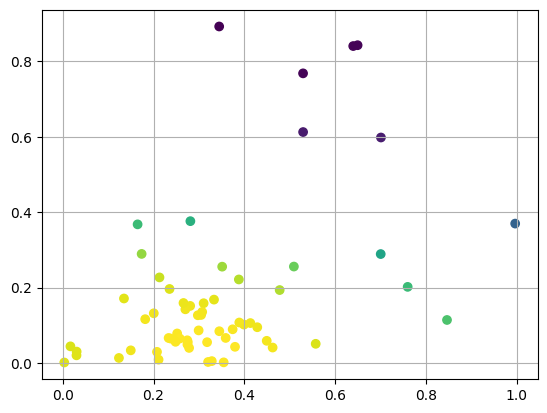

In [33]:
import matplotlib.pyplot as plt
plt.scatter(study.trials_dataframe()['params_alpha'],
            study.trials_dataframe()['params_beta'],
            c=study.trials_dataframe()['value'])
_ = plt.grid()

model traind
2023-03-19 04:26:47.113: 		0.03084197  	0.06817467  	0.05659393  


In [57]:
config['top_k'], config.top_k

([20], [20])

In [71]:
config

NeuRec:[NeuRec]:
recommender=SGL
dataset=yelp2018
file_column=UI
sep=','
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "NDCG"]
top_k=[20]
test_thread=8
test_batch_size=128
seed=2021
start_testing_epoch=0

SGL:[hyperparameters]:
aug_type=ED
reg=1e-4
embed_size=64
n_layers=3
ssl_reg=0.1
ssl_ratio=0.1
ssl_temp=0.2
ssl_mode=both_side
lr=0.001
learner=adam
adj_type=pre
epochs=1000
batch_size=2048
num_negatives=1
param_init=xavier_uniform
stddev=0.01
verbose=1
stop_cnt=10
pretrain_flag=0
save_flag=0

In [59]:
from collections import OrderedDict

In [60]:
d = OrderedDict()
d['asf'] = 0

In [61]:
d.asf

AttributeError: 'collections.OrderedDict' object has no attribute 'asf'